In [17]:
import os
import zipfile 

import glob
import cv2

import matplotlib.pyplot as plt
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [2]:
train_path = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/train/'
test_path = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/test/'

train_demented = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/train/ModerateDemented'
train_non_demented = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/train/NonDemented'
test_demented = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/test/ModerateDemented'
test_non_demented = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset/test/NonDemented'

In [27]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.imgs_path = folder_path
        file_list = glob.glob(self.imgs_path + '*')
        # print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            for img_path in glob.glob(class_path + '/*.jpg'):
                self.data.append([img_path, class_name])
        # print(self.data)
        self.class_map = {'ModerateDemented': 0, 'NonDemented': 1, 'MildDemented': 2, 'VeryMildDemented': 3}
        self.img_dim = (200, 200)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor  = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [28]:
train_dataset = CustomDataset(folder_path=train_path)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = CustomDataset(folder_path=test_path)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

print(dataset_sizes)

{'train': 5121, 'val': 1279}


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Feature batch shape: torch.Size([4, 3, 200, 200])
Labels batch shape: torch.Size([4, 1])


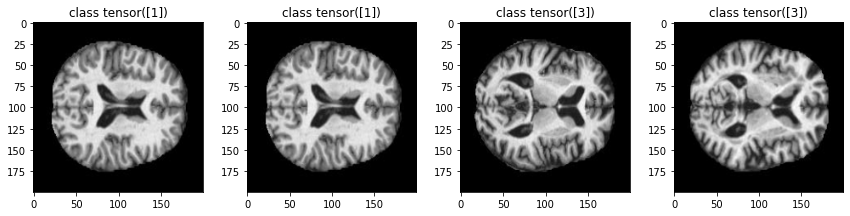

In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
fig, axs = plt.subplots(ncols=4, figsize=(12, 10))
plt.tight_layout(pad=1, h_pad=1, w_pad=1)
for i in range(4):
    idx = random.randint(0, 3)
    img = train_features[idx].squeeze()
    label = train_labels[idx]
    new_img = np.array([_img for _img in img.numpy()[::-1]])
    axs[i].imshow(new_img.T)
    axs[i].title.set_text(f'class {label}')
plt.show()

In [12]:
import time
import copy

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).flatten()
                # print(f'LABELS: {labels}')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # {train_features}

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
model_conv = models.resnet34(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1231 Acc: 0.5306
val Loss: 1.0443 Acc: 0.5473

Epoch 1/24
----------
train Loss: 1.0440 Acc: 0.5522
val Loss: 1.2210 Acc: 0.5371

Epoch 2/24
----------
train Loss: 1.0166 Acc: 0.5655
val Loss: 1.0876 Acc: 0.5137

Epoch 3/24
----------
train Loss: 0.9692 Acc: 0.5876
val Loss: 1.0666 Acc: 0.5301

Epoch 4/24
----------
train Loss: 1.0704 Acc: 0.5645
val Loss: 1.0935 Acc: 0.5168

Epoch 5/24
----------
train Loss: 1.0085 Acc: 0.5766
val Loss: 1.0261 Acc: 0.5590

Epoch 6/24
----------
train Loss: 0.9966 Acc: 0.5804
val Loss: 1.0549 Acc: 0.5723

Epoch 7/24
----------
train Loss: 0.7951 Acc: 0.6430
val Loss: 1.0483 Acc: 0.5301

Epoch 8/24
----------
train Loss: 0.7839 Acc: 0.6426
val Loss: 1.0142 Acc: 0.5473

Epoch 9/24
----------
train Loss: 0.7840 Acc: 0.6503
val Loss: 1.0230 Acc: 0.5410

Epoch 10/24
----------
train Loss: 0.7862 Acc: 0.6479
val Loss: 1.0912 Acc: 0.5113

Epoch 11/24
----------
train Loss: 0.7772 Acc: 0.6567
val Loss: 1.0014 Acc: 0.5684

Ep

KeyboardInterrupt: ignored